# Regularization and Optimization of Neural Networks - Lab

## Introduction

Recall from the last lab that we had a training accuracy close to 90% and a test set accuracy close to 76%.

As with our previous machine learning work, we should be asking a couple of questions:
- Is there a high bias? yes/no
- Is there a high variance? yes/no

Also recall that "high bias" is a relative concept. Knowing we have 7 classes and the topics are related, we'll assume that a 90% accuracy is pretty good and the bias on the training set is low. (We've also discussed concepts like precision, recall as well as AUC and ROC curves.)   

In this lab, we'll use the notion of training/validation/test set to get better insights of how we can mitigate our variance, and we'll look at a few regularization techniques. You'll start by repeating the process from the last section: importing the data and performing preprocessing including one-hot encoding. Then, just before you go on to train the model, we'll introduce how to include a validation set. You'll then define and compile the model as before. This time, when you are presented with the `history` dictionary of the model, you will have additional data entries for not only the train and test, but the train, test and validation  and then defigning, compiling and training the model. 


## Objectives

You will be able to:

* Construct and run a basic model in Keras
* Construct a validation set and explain potential benefits
* Apply L1 and L2 regularization
* Aplly dropout regularization
* Observe and comment on the effect of using more data

## Import the libraries

As usual, start by importing some of the packages and modules that you intend to use. The first thing we'll be doing is importing the data and taking a random sample, so that should clue you in to what tools to import. If you need more tools down the line, you can always import additional packages later.

In [1]:
#Your code here; import some packages/modules you plan to use
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer#Your code here; import some packages/modules you plan to use

Using TensorFlow backend.


## Load the Data

As with the previous lab, the data is stored in a file **Bank_complaints.csv**. Load and preview the dataset.

In [2]:
#Your code here; load and preview the dataset
df = pd.read_csv("Bank_complaints.csv")
df.head()

,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


## Preprocessing Overview

Before we begin to practice some of our new tools regarding regularization and optimization, let's practice munging some data as we did in the previous section with bank complaints. Recall some techniques:

* Sampling in order to reduce training time (investigate model accuracy vs data size later on)
* One-hot encoding our complaint text
* Transforming our category labels
* Train - test split

## Preprocessing: Generate a Random Sample

Since we have quite a bit of data and training networks takes a substantial amount of time and resources, we will downsample in order to test our initial pipeline. Going forward, these can be interesting areas of investigation: how does our models performance change as we increase (or decrease) the size of our dataset?  

Generate the random sample using seed 123 for consistency of results. Make your new sample have 10,000 observations.

In [3]:
#Your code here
random.seed(123)
df = df.sample(10000)
df.index = range(10000)
product = df["Product"]
complaints = df["Consumer complaint narrative"]

## Preprocessing: One-hot Encoding of the Complaints

As before, we need to do some preprocessing and data manipulationg before building the neural network. Last time, we guided you through the process, and now its time for you to practice that pipeline independently.  

Only keep 2,000 most common words and use one-hot encoding to reformat the complaints into a matrix of vectors.

In [4]:
#Your code here; use one-hot encoding to reformat the complaints into a matrix of vectors.
#Only keep the 2000 most common words.

tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(complaints)

one_hot_results= tokenizer.texts_to_matrix(complaints, mode='binary')
word_index = tokenizer.word_index
np.shape(one_hot_results)

(10000, 2000)

## Preprocessing: Encoding the Products

Similarly, now transform the descriptive product labels to integers labels. After transforming them to integer labels, retransform them into a matrix of binary flags, one for each of the various product labels.  
  
  (Note: this is similar to our previous work with dummy variables: each of the various product categories will be its own column, and each observation will be a row. Each of these observation rows will have a 1 in the column associated with it's label, and all other entries for the row will be zero.)

In [5]:
#Your code here; transform the product labels to numerical values
le = preprocessing.LabelEncoder()
le.fit(product)
product_cat = le.transform(product) 

#Then transform these integer values into a matrix of binary flags
product_onehot = to_categorical(product_cat)

## Train-test Split

Now onto the ever familiar train-test split! Be sure to split both the complaint data (now transformed into word vectors) as well as their associated labels. Perform an appropriate train test split.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_results, product_onehot, test_size=1500, random_state=42)

#Alternative custom script:
# random.seed(123)
# test_index = random.sample(range(1,10000), 1500)
# test = one_hot_results[test_index]
# train = np.delete(one_hot_results, test_index, 0)
# label_test = product_onehot[test_index]
# label_train = np.delete(product_onehot, test_index, 0)

## Running the model using a validation set.

## Creating the Validation Set

In the lecture we mentioned that in deep learning, we generally keep aside a validation set, which is used during hyperparameter tuning. Then when we have made the final model decision, the test set is used to define the final model perforance. 

In this example, let's take the first 1000 cases out of the training set to become the validation set. You should do this for both `train` and `label_train`.

In [7]:
#Just run this block of code 
random.seed(123)
val = X_train[:1000]
train_final = X_train[1000:]
label_val = y_train[:1000]
label_train_final = y_train[1000:]

## Creating the Model

Let's rebuild a fully connected (Dense) layer network with relu activations in Keras.

Recall that we used 2 hidden with 50 units in the first layer and 25 in the second, both with a `relu` activation function. Because we are dealing with a multiclass problem (classifying the complaints into 7 classes), we use a use a softmax classifyer in order to output 7 class probabilities per case.  



In [8]:
#Your code here; build a neural network using Keras as described above.
random.seed(123)
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

## Compiling the Model
In the compiler, you'll be passing the optimizer, loss function, and metrics. Train the model for 120 epochs in mini-batches of 256 samples. This time, let's include the argument `validation_data` and assign it `(val, label_val)`

In [10]:
#Your code here
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Part 2: Code Along

The remaining portion of this lab will introduce you to code snippets for a myriad of different methods discussed in the lecture.

## Training the Model

Ok, now for the resource intensive part: time to train our model! Note that this is where we also introduce the validation data to the model.

In [11]:
#Code provided; note the extra validation parameter passed.
model_val = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 71us/step - loss: 1.9527 - acc: 0.1555 - val_loss: 1.9378 - val_acc: 0.1720
Epoch 2/120
7500/7500 [==============================] - 0s 44us/step - loss: 1.9222 - acc: 0.1979 - val_loss: 1.9178 - val_acc: 0.2130
Epoch 3/120
7500/7500 [==============================] - 0s 44us/step - loss: 1.9005 - acc: 0.2281 - val_loss: 1.9004 - val_acc: 0.2340
Epoch 4/120
7500/7500 [==============================] - 0s 46us/step - loss: 1.8789 - acc: 0.2540 - val_loss: 1.8817 - val_acc: 0.2520
Epoch 5/120
7500/7500 [==============================] - 0s 44us/step - loss: 1.8547 - acc: 0.2749 - val_loss: 1.8597 - val_acc: 0.2690
Epoch 6/120
7500/7500 [==============================] - 0s 44us/step - loss: 1.8267 - acc: 0.3001 - val_loss: 1.8330 - val_acc: 0.2900
Epoch 7/120
7500/7500 [==============================] - 0s 41us/step - loss: 1.7937 - acc: 0.3257 - val_loss: 1.8007 - val_acc: 0.3140


7500/7500 [==============================] - 0s 40us/step - loss: 0.5740 - acc: 0.8025 - val_loss: 0.6814 - val_acc: 0.7480
Epoch 61/120
7500/7500 [==============================] - 0s 39us/step - loss: 0.5686 - acc: 0.8027 - val_loss: 0.6794 - val_acc: 0.7450
Epoch 62/120
7500/7500 [==============================] - 0s 39us/step - loss: 0.5633 - acc: 0.8019 - val_loss: 0.6813 - val_acc: 0.7400
Epoch 63/120
7500/7500 [==============================] - 0s 39us/step - loss: 0.5586 - acc: 0.8049 - val_loss: 0.6729 - val_acc: 0.7470
Epoch 64/120
7500/7500 [==============================] - 0s 39us/step - loss: 0.5528 - acc: 0.8075 - val_loss: 0.6695 - val_acc: 0.7430
Epoch 65/120
7500/7500 [==============================] - 0s 39us/step - loss: 0.5482 - acc: 0.8091 - val_loss: 0.6668 - val_acc: 0.7510
Epoch 66/120
7500/7500 [==============================] - 0s 40us/step - loss: 0.5433 - acc: 0.8129 - val_loss: 0.6675 - val_acc: 0.7530
Epoch 67/120
7500/7500 [==============================

Epoch 120/120
7500/7500 [==============================] - 0s 48us/step - loss: 0.3696 - acc: 0.8792 - val_loss: 0.6190 - val_acc: 0.7600


## Retrieving Performance Results: the `history` dictionary

The dictionary `history` contains four entries this time: one per metric that was being monitored during training and during validation.

In [12]:
model_val_dict = model_val.history
model_val_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [13]:
results_train = model.evaluate(train_final, label_train_final)

7500/7500 [==============================] - 0s 55us/step


In [14]:
results_test = model.evaluate(X_test, y_test)

1500/1500 [==============================] - 0s 58us/step


In [15]:
results_train

[0.3669822705030441, 0.8816]

In [16]:
results_test

[0.6777662576039633, 0.7519999995231629]

Note that the result isn't exactly the same as before. Note that this because the training set is slightly different! We remove 1000 instances for validation!

## Plotting the Results

Let's plot the result similarly to what we have done in the previous lab. This time though, let's include the training and the validation loss in the same plot. We'll do the same thing for the training and validation accuracy.

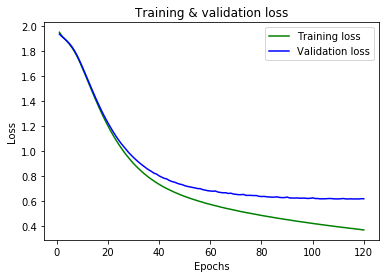

In [17]:
plt.clf()

import matplotlib.pyplot as plt
loss_values = model_val_dict['loss']
val_loss_values = model_val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

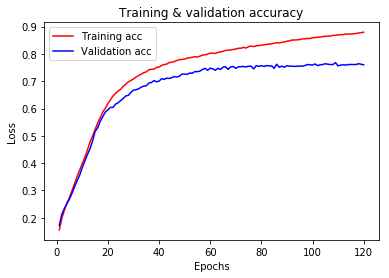

In [18]:
plt.clf()

acc_values = model_val_dict['acc'] 
val_acc_values = model_val_dict['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We observe an interesting pattern here: although the training accuracy keeps increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy and loss seem to be reaching a status quo around the 60th epoch. This means that we're actually **overfitting** to the train data when we do as many epochs as we were doing. Luckily, you learned how to tackle overfitting in the previous lecture! For starters, it does seem clear that we are training too long. So let's stop training at the 60th epoch first (so-called "early stopping") before we move to more advanced regularization techniques!

## Early Stopping

In [19]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model = model.fit(train_final,
                    label_train_final,
                    epochs=60,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/60
7500/7500 [==============================] - 1s 68us/step - loss: 1.9728 - acc: 0.1431 - val_loss: 1.9505 - val_acc: 0.1640
Epoch 2/60
7500/7500 [==============================] - 0s 49us/step - loss: 1.9409 - acc: 0.1717 - val_loss: 1.9291 - val_acc: 0.1820
Epoch 3/60
7500/7500 [==============================] - 0s 49us/step - loss: 1.9185 - acc: 0.1996 - val_loss: 1.9108 - val_acc: 0.1930
Epoch 4/60
7500/7500 [==============================] - 0s 48us/step - loss: 1.8973 - acc: 0.2263 - val_loss: 1.8919 - val_acc: 0.2180
Epoch 5/60
7500/7500 [==============================] - 0s 49us/step - loss: 1.8748 - acc: 0.2549 - val_loss: 1.8710 - val_acc: 0.2430
Epoch 6/60
7500/7500 [==============================] - 0s 50us/step - loss: 1.8503 - acc: 0.2773 - val_loss: 1.8464 - val_acc: 0.2780
Epoch 7/60
7500/7500 [==============================] - 0s 49us/step - loss: 1.8221 - acc: 0.3044 - val_loss: 1.8178 - val_acc: 0.3070
Epoch 8

7500/7500 [==============================] - 0s 47us/step - loss: 0.5805 - acc: 0.7963 - val_loss: 0.6912 - val_acc: 0.7310


Now, you can use the test set to make label predictions

In [20]:
results_train = model.evaluate(train_final, label_train_final)

7500/7500 [==============================] - 0s 45us/step


In [21]:
results_test = model.evaluate(X_test, y_test)

1500/1500 [==============================] - 0s 65us/step


In [22]:
results_train

[0.5761956606388092, 0.7996]

In [23]:
results_test

[0.747904699643453, 0.7253333328564961]

We've significantly reduced the variance, so this is already pretty good! Our test set accuracy is slightly worse, but this model will definitely be more robust than the 120 epochs one we fitted before.

Now, let's see what else we can do to improve the result!

## L2 Regularization

Let's include L2 regularization. You can easily do this in keras adding the argument kernel_regulizers.l2 and adding a value for the regularization parameter lambda between parentheses.

In [24]:
from keras import regularizers
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L2_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 73us/step - loss: 2.5979 - acc: 0.1409 - val_loss: 2.5992 - val_acc: 0.1380
Epoch 2/120
7500/7500 [==============================] - 0s 52us/step - loss: 2.5685 - acc: 0.1779 - val_loss: 2.5774 - val_acc: 0.1620
Epoch 3/120
7500/7500 [==============================] - 0s 49us/step - loss: 2.5454 - acc: 0.2067 - val_loss: 2.5577 - val_acc: 0.1870
Epoch 4/120
7500/7500 [==============================] - 0s 52us/step - loss: 2.5225 - acc: 0.2155 - val_loss: 2.5372 - val_acc: 0.1970
Epoch 5/120
7500/7500 [==============================] - 0s 51us/step - loss: 2.4981 - acc: 0.2259 - val_loss: 2.5151 - val_acc: 0.2020
Epoch 6/120
7500/7500 [==============================] - 0s 51us/step - loss: 2.4714 - acc: 0.2385 - val_loss: 2.4895 - val_acc: 0.2100
Epoch 7/120
7500/7500 [==============================] - 0s 53us/step - loss: 2.4410 - acc: 0.2596 - val_loss: 2.4605 - val_acc: 0.2340


7500/7500 [==============================] - 0s 59us/step - loss: 1.1541 - acc: 0.7851 - val_loss: 1.2510 - val_acc: 0.7260
Epoch 61/120
7500/7500 [==============================] - 0s 56us/step - loss: 1.1471 - acc: 0.7895 - val_loss: 1.2456 - val_acc: 0.7270
Epoch 62/120
7500/7500 [==============================] - 0s 48us/step - loss: 1.1402 - acc: 0.7907 - val_loss: 1.2390 - val_acc: 0.7320
Epoch 63/120
7500/7500 [==============================] - 0s 49us/step - loss: 1.1330 - acc: 0.7933 - val_loss: 1.2352 - val_acc: 0.7270
Epoch 64/120
7500/7500 [==============================] - 0s 49us/step - loss: 1.1261 - acc: 0.7949 - val_loss: 1.2300 - val_acc: 0.7340
Epoch 65/120
7500/7500 [==============================] - 0s 48us/step - loss: 1.1196 - acc: 0.7921 - val_loss: 1.2233 - val_acc: 0.7310
Epoch 66/120
7500/7500 [==============================] - 0s 48us/step - loss: 1.1129 - acc: 0.7961 - val_loss: 1.2192 - val_acc: 0.7320
Epoch 67/120
7500/7500 [==============================

7500/7500 [==============================] - 0s 48us/step - loss: 0.8674 - acc: 0.8604 - val_loss: 1.0631 - val_acc: 0.7520
Epoch 120/120
7500/7500 [==============================] - 0s 48us/step - loss: 0.8639 - acc: 0.8612 - val_loss: 1.0600 - val_acc: 0.7530


In [25]:
L2_model_dict = L2_model.history
L2_model_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Let's look at the training accuracy as well as the validation accuracy for both the L2 and the model without regularization (for 120 epochs).

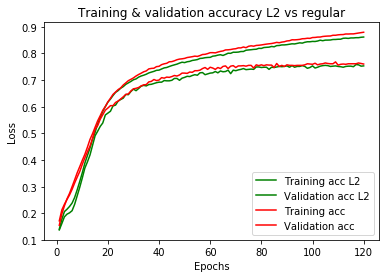

In [26]:
plt.clf()

acc_values = L2_model_dict['acc'] 
val_acc_values = L2_model_dict['val_acc']
model_acc = model_val_dict['acc']
model_val_acc = model_val_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc L2')
plt.plot(epochs, val_acc_values, 'g', label='Validation acc L2')
plt.plot(epochs, model_acc, 'r', label='Training acc')
plt.plot(epochs, model_val_acc, 'r', label='Validation acc')
plt.title('Training & validation accuracy L2 vs regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The results of L2 regularization are quite disappointing here. We notice the discrepancy between validation and training accuracy seems to have decreased slightly, but the end result is definitely not getting better. 

## L1 Regularization

Let's have a look at L1 regularization. Will this work better?

In [27]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 80us/step - loss: 15.9777 - acc: 0.1621 - val_loss: 15.5696 - val_acc: 0.1610
Epoch 2/120
7500/7500 [==============================] - 0s 52us/step - loss: 15.2117 - acc: 0.1912 - val_loss: 14.8219 - val_acc: 0.1790
Epoch 3/120
7500/7500 [==============================] - 0s 51us/step - loss: 14.4714 - acc: 0.2176 - val_loss: 14.0959 - val_acc: 0.2010
Epoch 4/120
7500/7500 [==============================] - 0s 52us/step - loss: 13.7507 - acc: 0.2405 - val_loss: 13.3888 - val_acc: 0.2200
Epoch 5/120
7500/7500 [==============================] - 0s 53us/step - loss: 13.0484 - acc: 0.2595 - val_loss: 12.6998 - val_acc: 0.2350
Epoch 6/120
7500/7500 [==============================] - 0s 50us/step - loss: 12.3636 - acc: 0.2776 - val_loss: 12.0283 - val_acc: 0.2570
Epoch 7/120
7500/7500 [==============================] - 0s 52us/step - loss: 11.6974 - acc: 0.3019 - val_loss: 11.3759 - va

7500/7500 [==============================] - 0s 51us/step - loss: 1.6862 - acc: 0.7116 - val_loss: 1.6988 - val_acc: 0.7080
Epoch 61/120
7500/7500 [==============================] - 0s 51us/step - loss: 1.6762 - acc: 0.7115 - val_loss: 1.6885 - val_acc: 0.7120
Epoch 62/120
7500/7500 [==============================] - 0s 49us/step - loss: 1.6674 - acc: 0.7113 - val_loss: 1.6785 - val_acc: 0.7130
Epoch 63/120
7500/7500 [==============================] - 0s 52us/step - loss: 1.6581 - acc: 0.7128 - val_loss: 1.6708 - val_acc: 0.7090
Epoch 64/120
7500/7500 [==============================] - 0s 51us/step - loss: 1.6495 - acc: 0.7128 - val_loss: 1.6642 - val_acc: 0.7090
Epoch 65/120
7500/7500 [==============================] - 0s 50us/step - loss: 1.6409 - acc: 0.7125 - val_loss: 1.6559 - val_acc: 0.7020
Epoch 66/120
7500/7500 [==============================] - 0s 49us/step - loss: 1.6326 - acc: 0.7133 - val_loss: 1.6438 - val_acc: 0.7130
Epoch 67/120
7500/7500 [==============================

Epoch 120/120
7500/7500 [==============================] - 0s 54us/step - loss: 1.3051 - acc: 0.7296 - val_loss: 1.3195 - val_acc: 0.7230


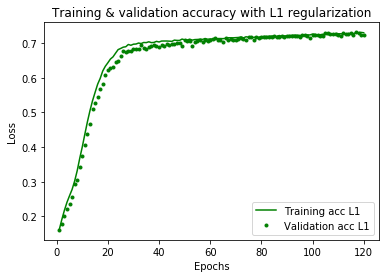

In [28]:
L1_model_dict = L1_model.history
plt.clf()

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc L1')
plt.plot(epochs, val_acc_values, 'g.', label='Validation acc L1')
plt.title('Training & validation accuracy with L1 regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Notice how The training and validation accuracy don't diverge as much as before! Unfortunately, the validation accuracy doesn't reach rates much higher than 70%. It does seem like we can still improve the model by training much longer.

In [29]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(train_final,
                    label_train_final,
                    epochs=1000,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/1000
7500/7500 [==============================] - 1s 80us/step - loss: 16.0708 - acc: 0.1621 - val_loss: 15.6637 - val_acc: 0.1660
Epoch 2/1000
7500/7500 [==============================] - 0s 52us/step - loss: 15.3031 - acc: 0.1965 - val_loss: 14.9173 - val_acc: 0.1860
Epoch 3/1000
7500/7500 [==============================] - 0s 52us/step - loss: 14.5653 - acc: 0.2124 - val_loss: 14.1949 - val_acc: 0.1960
Epoch 4/1000
7500/7500 [==============================] - 0s 58us/step - loss: 13.8503 - acc: 0.2167 - val_loss: 13.4937 - val_acc: 0.2060
Epoch 5/1000
7500/7500 [==============================] - 0s 59us/step - loss: 13.1559 - acc: 0.2303 - val_loss: 12.8120 - val_acc: 0.2090
Epoch 6/1000
7500/7500 [==============================] - 0s 52us/step - loss: 12.4803 - acc: 0.2391 - val_loss: 12.1484 - val_acc: 0.2190
Epoch 7/1000
7500/7500 [==============================] - 0s 51us/step - loss: 11.8241 - acc: 0.2603 - val_loss: 11.50

Epoch 60/1000
7500/7500 [==============================] - 0s 49us/step - loss: 1.7176 - acc: 0.7029 - val_loss: 1.7308 - val_acc: 0.7080
Epoch 61/1000
7500/7500 [==============================] - 0s 48us/step - loss: 1.7075 - acc: 0.7045 - val_loss: 1.7204 - val_acc: 0.7050
Epoch 62/1000
7500/7500 [==============================] - 0s 48us/step - loss: 1.6979 - acc: 0.7044 - val_loss: 1.7109 - val_acc: 0.7130
Epoch 63/1000
7500/7500 [==============================] - 0s 48us/step - loss: 1.6881 - acc: 0.7056 - val_loss: 1.7012 - val_acc: 0.7070
Epoch 64/1000
7500/7500 [==============================] - 0s 49us/step - loss: 1.6783 - acc: 0.7079 - val_loss: 1.6920 - val_acc: 0.7080
Epoch 65/1000
7500/7500 [==============================] - 0s 49us/step - loss: 1.6693 - acc: 0.7072 - val_loss: 1.6806 - val_acc: 0.7110
Epoch 66/1000
7500/7500 [==============================] - 0s 48us/step - loss: 1.6600 - acc: 0.7076 - val_loss: 1.6762 - val_acc: 0.7120
Epoch 67/1000
7500/7500 [=========

7500/7500 [==============================] - 0s 49us/step - loss: 1.3171 - acc: 0.7283 - val_loss: 1.3349 - val_acc: 0.7210
Epoch 120/1000
7500/7500 [==============================] - 0s 61us/step - loss: 1.3116 - acc: 0.7291 - val_loss: 1.3292 - val_acc: 0.7150
Epoch 121/1000
7500/7500 [==============================] - 0s 51us/step - loss: 1.3072 - acc: 0.7304 - val_loss: 1.3249 - val_acc: 0.7100
Epoch 122/1000
7500/7500 [==============================] - 0s 60us/step - loss: 1.3030 - acc: 0.7287 - val_loss: 1.3182 - val_acc: 0.7160
Epoch 123/1000
7500/7500 [==============================] - 0s 52us/step - loss: 1.2973 - acc: 0.7312 - val_loss: 1.3143 - val_acc: 0.7220
Epoch 124/1000
7500/7500 [==============================] - 1s 77us/step - loss: 1.2934 - acc: 0.7315 - val_loss: 1.3111 - val_acc: 0.7180
Epoch 125/1000
7500/7500 [==============================] - 0s 65us/step - loss: 1.2896 - acc: 0.7301 - val_loss: 1.3077 - val_acc: 0.7140
Epoch 126/1000
7500/7500 [================

7500/7500 [==============================] - 0s 56us/step - loss: 1.1259 - acc: 0.7427 - val_loss: 1.1483 - val_acc: 0.7150
Epoch 179/1000
7500/7500 [==============================] - 0s 58us/step - loss: 1.1237 - acc: 0.7441 - val_loss: 1.1463 - val_acc: 0.7220
Epoch 180/1000
7500/7500 [==============================] - 0s 54us/step - loss: 1.1211 - acc: 0.7452 - val_loss: 1.1515 - val_acc: 0.7180
Epoch 181/1000
7500/7500 [==============================] - 0s 51us/step - loss: 1.1199 - acc: 0.7456 - val_loss: 1.1434 - val_acc: 0.7250
Epoch 182/1000
7500/7500 [==============================] - 0s 53us/step - loss: 1.1176 - acc: 0.7441 - val_loss: 1.1457 - val_acc: 0.7180
Epoch 183/1000
7500/7500 [==============================] - 0s 53us/step - loss: 1.1163 - acc: 0.7432 - val_loss: 1.1437 - val_acc: 0.7230
Epoch 184/1000
7500/7500 [==============================] - 0s 52us/step - loss: 1.1141 - acc: 0.7440 - val_loss: 1.1377 - val_acc: 0.7270
Epoch 185/1000
7500/7500 [================

7500/7500 [==============================] - 0s 52us/step - loss: 1.0483 - acc: 0.7524 - val_loss: 1.0804 - val_acc: 0.7320
Epoch 238/1000
7500/7500 [==============================] - 0s 51us/step - loss: 1.0475 - acc: 0.7543 - val_loss: 1.0764 - val_acc: 0.7270
Epoch 239/1000
7500/7500 [==============================] - 0s 48us/step - loss: 1.0464 - acc: 0.7543 - val_loss: 1.0774 - val_acc: 0.7300
Epoch 240/1000
7500/7500 [==============================] - 0s 51us/step - loss: 1.0455 - acc: 0.7527 - val_loss: 1.0855 - val_acc: 0.7320
Epoch 241/1000
7500/7500 [==============================] - 0s 50us/step - loss: 1.0456 - acc: 0.7516 - val_loss: 1.0767 - val_acc: 0.7320
Epoch 242/1000
7500/7500 [==============================] - 0s 48us/step - loss: 1.0437 - acc: 0.7511 - val_loss: 1.0759 - val_acc: 0.7310
Epoch 243/1000
7500/7500 [==============================] - 0s 49us/step - loss: 1.0430 - acc: 0.7540 - val_loss: 1.0733 - val_acc: 0.7330
Epoch 244/1000
7500/7500 [================

7500/7500 [==============================] - 0s 51us/step - loss: 1.0017 - acc: 0.7583 - val_loss: 1.0400 - val_acc: 0.7350
Epoch 297/1000
7500/7500 [==============================] - 0s 50us/step - loss: 1.0021 - acc: 0.7588 - val_loss: 1.0387 - val_acc: 0.7350
Epoch 298/1000
7500/7500 [==============================] - 0s 49us/step - loss: 1.0005 - acc: 0.7588 - val_loss: 1.0434 - val_acc: 0.7380
Epoch 299/1000
7500/7500 [==============================] - 0s 49us/step - loss: 1.0005 - acc: 0.7581 - val_loss: 1.0400 - val_acc: 0.7340
Epoch 300/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.9995 - acc: 0.7579 - val_loss: 1.0365 - val_acc: 0.7440
Epoch 301/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.9989 - acc: 0.7608 - val_loss: 1.0377 - val_acc: 0.7350
Epoch 302/1000
7500/7500 [==============================] - ETA: 0s - loss: 0.9975 - acc: 0.762 - 0s 48us/step - loss: 0.9977 - acc: 0.7613 - val_loss: 1.0341 - val_acc: 0.7350
Epoc

Epoch 355/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.9702 - acc: 0.7624 - val_loss: 1.0096 - val_acc: 0.7420
Epoch 356/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.9694 - acc: 0.7636 - val_loss: 1.0093 - val_acc: 0.7410
Epoch 357/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.9677 - acc: 0.7648 - val_loss: 1.0151 - val_acc: 0.7370
Epoch 358/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.9678 - acc: 0.7636 - val_loss: 1.0103 - val_acc: 0.7420
Epoch 359/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.9676 - acc: 0.7640 - val_loss: 1.0112 - val_acc: 0.7400
Epoch 360/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.9671 - acc: 0.7639 - val_loss: 1.0198 - val_acc: 0.7450
Epoch 361/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.9673 - acc: 0.7637 - val_loss: 1.0106 - val_acc: 0.7410
Epoch 362/1000
7500/7500 [=

7500/7500 [==============================] - 0s 58us/step - loss: 0.9432 - acc: 0.7693 - val_loss: 0.9940 - val_acc: 0.7420
Epoch 414/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.9426 - acc: 0.7692 - val_loss: 0.9878 - val_acc: 0.7450
Epoch 415/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.9423 - acc: 0.7703 - val_loss: 0.9863 - val_acc: 0.7510
Epoch 416/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.9416 - acc: 0.7693 - val_loss: 0.9877 - val_acc: 0.7430
Epoch 417/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.9419 - acc: 0.7704 - val_loss: 0.9857 - val_acc: 0.7500
Epoch 418/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.9404 - acc: 0.7699 - val_loss: 0.9994 - val_acc: 0.7390
Epoch 419/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.9397 - acc: 0.7708 - val_loss: 0.9918 - val_acc: 0.7430
Epoch 420/1000
7500/7500 [================

7500/7500 [==============================] - 0s 51us/step - loss: 0.9204 - acc: 0.7748 - val_loss: 0.9769 - val_acc: 0.7460
Epoch 473/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.9197 - acc: 0.7737 - val_loss: 0.9706 - val_acc: 0.7540
Epoch 474/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.9184 - acc: 0.7703 - val_loss: 0.9682 - val_acc: 0.7590
Epoch 475/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.9186 - acc: 0.7745 - val_loss: 0.9733 - val_acc: 0.7490
Epoch 476/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.9177 - acc: 0.7737 - val_loss: 0.9691 - val_acc: 0.7540
Epoch 477/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.9186 - acc: 0.7720 - val_loss: 0.9701 - val_acc: 0.7520
Epoch 478/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.9169 - acc: 0.7748 - val_loss: 0.9691 - val_acc: 0.7470
Epoch 479/1000
7500/7500 [================

Epoch 531/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8988 - acc: 0.7799 - val_loss: 0.9565 - val_acc: 0.7540
Epoch 532/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8978 - acc: 0.7793 - val_loss: 0.9566 - val_acc: 0.7520
Epoch 533/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8981 - acc: 0.7796 - val_loss: 0.9494 - val_acc: 0.7640
Epoch 534/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8989 - acc: 0.7797 - val_loss: 0.9754 - val_acc: 0.7430
Epoch 535/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8982 - acc: 0.7809 - val_loss: 0.9488 - val_acc: 0.7580
Epoch 536/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8971 - acc: 0.7800 - val_loss: 0.9468 - val_acc: 0.7600
Epoch 537/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.8970 - acc: 0.7797 - val_loss: 0.9539 - val_acc: 0.7550
Epoch 538/1000
7500/7500 [=

Epoch 590/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8835 - acc: 0.7867 - val_loss: 0.9405 - val_acc: 0.7600
Epoch 591/1000
7500/7500 [==============================] - 0s 53us/step - loss: 0.8833 - acc: 0.7844 - val_loss: 0.9473 - val_acc: 0.7530
Epoch 592/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.8800 - acc: 0.7856 - val_loss: 0.9540 - val_acc: 0.7560
Epoch 593/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8825 - acc: 0.7872 - val_loss: 0.9500 - val_acc: 0.7560
Epoch 594/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8821 - acc: 0.7857 - val_loss: 0.9446 - val_acc: 0.7580
Epoch 595/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8786 - acc: 0.7868 - val_loss: 0.9423 - val_acc: 0.7580
Epoch 596/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8803 - acc: 0.7863 - val_loss: 0.9434 - val_acc: 0.7520
Epoch 597/1000
7500/7500 [=

Epoch 649/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.8684 - acc: 0.7932 - val_loss: 0.9453 - val_acc: 0.7600
Epoch 650/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8674 - acc: 0.7933 - val_loss: 0.9375 - val_acc: 0.7590
Epoch 651/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.8651 - acc: 0.7925 - val_loss: 0.9761 - val_acc: 0.7390
Epoch 652/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8666 - acc: 0.7915 - val_loss: 0.9272 - val_acc: 0.7630
Epoch 653/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8658 - acc: 0.7945 - val_loss: 0.9362 - val_acc: 0.7600
Epoch 654/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8656 - acc: 0.7913 - val_loss: 0.9222 - val_acc: 0.7630
Epoch 655/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8646 - acc: 0.7936 - val_loss: 0.9827 - val_acc: 0.7520
Epoch 656/1000
7500/7500 [=

Epoch 708/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8527 - acc: 0.8001 - val_loss: 0.9225 - val_acc: 0.7640
Epoch 709/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8529 - acc: 0.7983 - val_loss: 0.9239 - val_acc: 0.7670
Epoch 710/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8522 - acc: 0.7993 - val_loss: 0.9331 - val_acc: 0.7650
Epoch 711/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.8547 - acc: 0.7979 - val_loss: 0.9140 - val_acc: 0.7680
Epoch 712/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8511 - acc: 0.7995 - val_loss: 0.9271 - val_acc: 0.7690
Epoch 713/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8539 - acc: 0.7981 - val_loss: 0.9438 - val_acc: 0.7710
Epoch 714/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8554 - acc: 0.7987 - val_loss: 0.9288 - val_acc: 0.7640
Epoch 715/1000
7500/7500 [=

Epoch 767/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8425 - acc: 0.8039 - val_loss: 0.9175 - val_acc: 0.7670
Epoch 768/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8444 - acc: 0.8043 - val_loss: 0.9889 - val_acc: 0.7560
Epoch 769/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.8485 - acc: 0.8008 - val_loss: 0.9234 - val_acc: 0.7710
Epoch 770/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8426 - acc: 0.8015 - val_loss: 0.9260 - val_acc: 0.7720
Epoch 771/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8458 - acc: 0.8028 - val_loss: 0.9481 - val_acc: 0.7570
Epoch 772/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8430 - acc: 0.8043 - val_loss: 0.9397 - val_acc: 0.7630
Epoch 773/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.8435 - acc: 0.7999 - val_loss: 0.9399 - val_acc: 0.7610
Epoch 774/1000
7500/7500 [=

Epoch 826/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8340 - acc: 0.8091 - val_loss: 0.9256 - val_acc: 0.7740
Epoch 827/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8309 - acc: 0.8108 - val_loss: 0.9085 - val_acc: 0.7690
Epoch 828/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8345 - acc: 0.8072 - val_loss: 0.9120 - val_acc: 0.7700
Epoch 829/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8315 - acc: 0.8085 - val_loss: 0.9121 - val_acc: 0.7760
Epoch 830/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.8320 - acc: 0.8067 - val_loss: 0.9146 - val_acc: 0.7600
Epoch 831/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8346 - acc: 0.8052 - val_loss: 0.9048 - val_acc: 0.7690
Epoch 832/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8292 - acc: 0.8101 - val_loss: 0.9269 - val_acc: 0.7700
Epoch 833/1000
7500/7500 [=

7500/7500 [==============================] - 0s 53us/step - loss: 0.8269 - acc: 0.8099 - val_loss: 0.9278 - val_acc: 0.7660
Epoch 885/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8278 - acc: 0.8095 - val_loss: 0.9032 - val_acc: 0.7860
Epoch 886/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8233 - acc: 0.8107 - val_loss: 0.9551 - val_acc: 0.7560
Epoch 887/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8289 - acc: 0.8099 - val_loss: 0.9437 - val_acc: 0.7570
Epoch 888/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8288 - acc: 0.8123 - val_loss: 0.9395 - val_acc: 0.7570
Epoch 889/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8233 - acc: 0.8119 - val_loss: 0.9962 - val_acc: 0.7360
Epoch 890/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8277 - acc: 0.8096 - val_loss: 0.9029 - val_acc: 0.7810
Epoch 891/1000
7500/7500 [================

7500/7500 [==============================] - 0s 49us/step - loss: 0.8149 - acc: 0.8156 - val_loss: 0.9390 - val_acc: 0.7710
Epoch 944/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.8196 - acc: 0.8161 - val_loss: 0.9012 - val_acc: 0.7780
Epoch 945/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8187 - acc: 0.8153 - val_loss: 0.9908 - val_acc: 0.7410
Epoch 946/1000
7500/7500 [==============================] - 0s 53us/step - loss: 0.8171 - acc: 0.8153 - val_loss: 0.8959 - val_acc: 0.7830
Epoch 947/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.8181 - acc: 0.8177 - val_loss: 0.9009 - val_acc: 0.7890
Epoch 948/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.8165 - acc: 0.8189 - val_loss: 0.9089 - val_acc: 0.7760
Epoch 949/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8175 - acc: 0.8149 - val_loss: 0.9174 - val_acc: 0.7810
Epoch 950/1000
7500/7500 [================

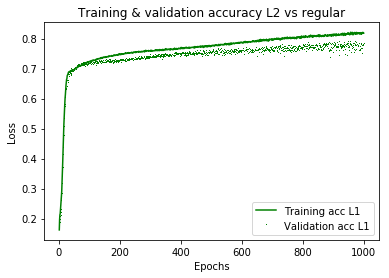

In [30]:
L1_model_dict = L1_model.history
plt.clf()

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc L1')
plt.plot(epochs, val_acc_values, 'g,', label='Validation acc L1')
plt.title('Training & validation accuracy L2 vs regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
results_train = model.evaluate(train_final, label_train_final)

results_test = model.evaluate(X_test, y_test)

1500/1500 [==============================] - 0s 53us/step


In [32]:
results_train

[0.8089194829622904, 0.8201333333651225]

In [33]:
results_test

[0.9813235403696696, 0.7619999996821085]

This is about the best we've seen so far, but we were training for quite a while! Let's see if dropout regularization can do even better and/or be more efficient!

## Dropout Regularization

In [34]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dropout(0.3, input_shape=(2000,)))
model.add(layers.Dense(50, activation='relu')) #2 hidden layers
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

dropout_model = model.fit(train_final,
                    label_train_final,
                    epochs=200,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/200
7500/7500 [==============================] - 1s 124us/step - loss: 1.9690 - acc: 0.1505 - val_loss: 1.9406 - val_acc: 0.1650
Epoch 2/200
7500/7500 [==============================] - 1s 85us/step - loss: 1.9548 - acc: 0.1567 - val_loss: 1.9328 - val_acc: 0.1810
Epoch 3/200
7500/7500 [==============================] - 1s 87us/step - loss: 1.9460 - acc: 0.1647 - val_loss: 1.9264 - val_acc: 0.1880
Epoch 4/200
7500/7500 [==============================] - ETA: 0s - loss: 1.9426 - acc: 0.175 - 1s 84us/step - loss: 1.9428 - acc: 0.1752 - val_loss: 1.9204 - val_acc: 0.2040
Epoch 5/200
7500/7500 [==============================] - 1s 85us/step - loss: 1.9301 - acc: 0.1837 - val_loss: 1.9148 - val_acc: 0.2190
Epoch 6/200
7500/7500 [==============================] - 1s 86us/step - loss: 1.9236 - acc: 0.1953 - val_loss: 1.9093 - val_acc: 0.2280
Epoch 7/200
7500/7500 [==============================] - 1s 86us/step - loss: 1.9165 - acc: 0.202

7500/7500 [==============================] - 1s 85us/step - loss: 1.2088 - acc: 0.5512 - val_loss: 0.9930 - val_acc: 0.6900
Epoch 61/200
7500/7500 [==============================] - 1s 87us/step - loss: 1.1969 - acc: 0.5477 - val_loss: 0.9830 - val_acc: 0.6940
Epoch 62/200
7500/7500 [==============================] - 1s 84us/step - loss: 1.1977 - acc: 0.5516 - val_loss: 0.9738 - val_acc: 0.6950
Epoch 63/200
7500/7500 [==============================] - 1s 85us/step - loss: 1.1886 - acc: 0.5625 - val_loss: 0.9660 - val_acc: 0.6970
Epoch 64/200
7500/7500 [==============================] - 1s 85us/step - loss: 1.1855 - acc: 0.5579 - val_loss: 0.9577 - val_acc: 0.7000
Epoch 65/200
7500/7500 [==============================] - 1s 83us/step - loss: 1.1570 - acc: 0.5639 - val_loss: 0.9489 - val_acc: 0.6980
Epoch 66/200
7500/7500 [==============================] - 1s 85us/step - loss: 1.1589 - acc: 0.5687 - val_loss: 0.9414 - val_acc: 0.6960
Epoch 67/200
7500/7500 [==============================

Epoch 120/200
7500/7500 [==============================] - 1s 84us/step - loss: 0.9080 - acc: 0.6587 - val_loss: 0.7148 - val_acc: 0.7290
Epoch 121/200
7500/7500 [==============================] - 1s 83us/step - loss: 0.9052 - acc: 0.6627 - val_loss: 0.7139 - val_acc: 0.7300
Epoch 122/200
7500/7500 [==============================] - 1s 84us/step - loss: 0.9200 - acc: 0.6521 - val_loss: 0.7164 - val_acc: 0.7270
Epoch 123/200
7500/7500 [==============================] - 1s 86us/step - loss: 0.9056 - acc: 0.6625 - val_loss: 0.7125 - val_acc: 0.7250
Epoch 124/200
7500/7500 [==============================] - 1s 84us/step - loss: 0.8857 - acc: 0.6747 - val_loss: 0.7078 - val_acc: 0.7280
Epoch 125/200
7500/7500 [==============================] - 1s 85us/step - loss: 0.9093 - acc: 0.6584 - val_loss: 0.7079 - val_acc: 0.7250
Epoch 126/200
7500/7500 [==============================] - 1s 84us/step - loss: 0.8947 - acc: 0.6661 - val_loss: 0.7056 - val_acc: 0.7300
Epoch 127/200
7500/7500 [=========

7500/7500 [==============================] - 1s 85us/step - loss: 0.7847 - acc: 0.7088 - val_loss: 0.6369 - val_acc: 0.7460
Epoch 180/200
7500/7500 [==============================] - 1s 93us/step - loss: 0.7758 - acc: 0.7125 - val_loss: 0.6371 - val_acc: 0.7480
Epoch 181/200
7500/7500 [==============================] - 1s 87us/step - loss: 0.7842 - acc: 0.7063 - val_loss: 0.6360 - val_acc: 0.7490
Epoch 182/200
7500/7500 [==============================] - 1s 86us/step - loss: 0.7806 - acc: 0.7067 - val_loss: 0.6369 - val_acc: 0.7520
Epoch 183/200
7500/7500 [==============================] - 1s 84us/step - loss: 0.7867 - acc: 0.7108 - val_loss: 0.6366 - val_acc: 0.7500
Epoch 184/200
7500/7500 [==============================] - 1s 92us/step - loss: 0.7752 - acc: 0.7085 - val_loss: 0.6335 - val_acc: 0.7520
Epoch 185/200
7500/7500 [==============================] - 1s 85us/step - loss: 0.7723 - acc: 0.7160 - val_loss: 0.6328 - val_acc: 0.7490
Epoch 186/200
7500/7500 [=======================

In [35]:
results_train = model.evaluate(train_final, label_train_final)
results_test = model.evaluate(X_test, y_test)

1500/1500 [==============================] - 0s 59us/step


In [36]:
results_train

[0.4714420175631841, 0.8345333333333333]

In [37]:
results_test

[0.6543982555071512, 0.7473333333333333]

You can see here that the validation performance has improved again! the variance did become higher again compared to L1-regularization.

## Bigger Data?

In the lecture, one of the solutions to high variance was just getting more data. We actually *have* more data, but took a subset of 10,000 units before. Let's now quadruple our data set, and see what happens. Note that we are really just lucky here, and getting more data isn't always possible, but this is a useful exercise in order to understand the power of big data sets.

In [38]:
df = pd.read_csv('Bank_complaints.csv')
random.seed(123)
df = df.sample(40000)
df.index = range(40000)
product = df["Product"]
complaints = df["Consumer complaint narrative"]

#one-hot encoding of the complaints
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(complaints)
sequences = tokenizer.texts_to_sequences(complaints)
one_hot_results= tokenizer.texts_to_matrix(complaints, mode='binary')
word_index = tokenizer.word_index
np.shape(one_hot_results)

#one-hot encoding of products
le = preprocessing.LabelEncoder()
le.fit(product)
list(le.classes_)
product_cat = le.transform(product) 
product_onehot = to_categorical(product_cat)

# train test split
test_index = random.sample(range(1,40000), 4000)
test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)
label_test = product_onehot[test_index]
label_train = np.delete(product_onehot, test_index, 0)

#Validation set
random.seed(123)
val = train[:3000]
train_final = train[3000:]
label_val = label_train[:3000]
label_train_final = label_train[3000:]

In [39]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

moredata_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 33000 samples, validate on 3000 samples
Epoch 1/120
33000/33000 [==============================] - 2s 57us/step - loss: 1.8902 - acc: 0.2218 - val_loss: 1.8295 - val_acc: 0.2730
Epoch 2/120
33000/33000 [==============================] - 2s 48us/step - loss: 1.7618 - acc: 0.3201 - val_loss: 1.6768 - val_acc: 0.3770
Epoch 3/120
33000/33000 [==============================] - 2s 49us/step - loss: 1.5970 - acc: 0.4154 - val_loss: 1.5088 - val_acc: 0.4540
Epoch 4/120
33000/33000 [==============================] - 2s 47us/step - loss: 1.4269 - acc: 0.5002 - val_loss: 1.3465 - val_acc: 0.5357
Epoch 5/120
33000/33000 [==============================] - 2s 46us/step - loss: 1.2700 - acc: 0.5835 - val_loss: 1.2045 - val_acc: 0.6137
Epoch 6/120
33000/33000 [==============================] - 2s 47us/step - loss: 1.1342 - acc: 0.6425 - val_loss: 1.0822 - val_acc: 0.6483
Epoch 7/120
33000/33000 [==============================] - 2s 47us/step - loss: 1.0188 - acc: 0.6765 - val_loss: 0.9813 - v

33000/33000 [==============================] - 2s 47us/step - loss: 0.4120 - acc: 0.8548 - val_loss: 0.5302 - val_acc: 0.8127
Epoch 60/120
33000/33000 [==============================] - 2s 47us/step - loss: 0.4100 - acc: 0.8555 - val_loss: 0.5293 - val_acc: 0.8137
Epoch 61/120
33000/33000 [==============================] - 2s 47us/step - loss: 0.4077 - acc: 0.8558 - val_loss: 0.5278 - val_acc: 0.8113
Epoch 62/120
33000/33000 [==============================] - 2s 46us/step - loss: 0.4051 - acc: 0.8565 - val_loss: 0.5293 - val_acc: 0.8093
Epoch 63/120
33000/33000 [==============================] - 2s 47us/step - loss: 0.4032 - acc: 0.8573 - val_loss: 0.5268 - val_acc: 0.8120
Epoch 64/120
33000/33000 [==============================] - 2s 47us/step - loss: 0.4005 - acc: 0.8595 - val_loss: 0.5281 - val_acc: 0.8120
Epoch 65/120
33000/33000 [==============================] - 2s 47us/step - loss: 0.3982 - acc: 0.8603 - val_loss: 0.5315 - val_acc: 0.8163
Epoch 66/120
33000/33000 [==============

Epoch 118/120
33000/33000 [==============================] - 2s 48us/step - loss: 0.3148 - acc: 0.8914 - val_loss: 0.5524 - val_acc: 0.8117
Epoch 119/120
33000/33000 [==============================] - 2s 46us/step - loss: 0.3134 - acc: 0.8917 - val_loss: 0.5533 - val_acc: 0.8120
Epoch 120/120
33000/33000 [==============================] - 2s 47us/step - loss: 0.3124 - acc: 0.8921 - val_loss: 0.5560 - val_acc: 0.8097


In [40]:
results_train = model.evaluate(train_final, label_train_final)
results_test = model.evaluate(test, label_test)

4000/4000 [==============================] - 0s 48us/step


In [41]:
results_train

[0.3092427464687463, 0.8932727272727272]

In [42]:
results_test

[0.5509318904876709, 0.80475]

With the same amount of epochs, we were able to get a fairly similar validation accuracy of 89.67 (compared to 88.55 in obtained in the first model in this lab). Our test set accuracy went up from 75.8 to a staggering 80.225% though, without any other regularization technique. You can still consider early stopping, L1, L2 and dropout here. It's clear that having more data has a strong impact on model performance!

## Additional Resources

* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb
* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
* https://catalog.data.gov/dataset/consumer-complaint-database

## Summary  

In this lesson, we not only built an initial deep-learning model, we then used a validation set to tune our model using various types of regularization. From here, we'll continue to describe more practice and theory regarding tuning and optimizing deep-learning networks.